<a href="https://colab.research.google.com/github/Meetra21/ECG_Heartbeat/blob/main/ECG_Classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About Dataset**

**ECG Heartbeat Categorization Dataset**


This dataset is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. The number of samples in both collections is large enough for training a deep neural network.

This dataset has been used in exploring heartbeat classification using deep neural network architectures, and observing some of the capabilities of transfer learning on it. The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat.

**Content**

**Arrhythmia Dataset**

Number of Samples: 109446

Number of Categories: 5

Sampling Frequency: 125Hz

Data Source:

Physionet's MIT-BIH Arrhythmia Dataset
Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

**The PTB Diagnostic ECG Database**

Number of Samples: 14552

Number of Categories: 2

Sampling Frequency: 125Hz

Data Source:

Physionet's PTB Diagnostic Database

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

**Data Files**

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

**Acknowledgements**

Mohammad Kachuee, Shayan Fazeli, and Majid Sarrafzadeh. "ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).

**Inspiration**

Can you identify myocardial infarction?

INTRODUCTION

In this notebook i want to predict different arrhytmia on ECG. We have two different dataset, but i will consider at start only one : mitbih. The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample. souces : https://physionet.org/content/mitdb/1.0.0/

Arrhythmia Dataset

Number of Samples: 109446
Number of Categories: 5
Sampling Frequency: 125Hz
Data Source: Physionet's MIT-BIH Arrhythmia Dataset

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Non-ecotic beats (normal beat) -S : Supraventricular ectopic beats -V : Ventricular ectopic beats -F : Fusion Beats -Q : Unknown Beats

What is an ecg?

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats.

These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

An ECG may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP. That's the result of

In [ ]:
import os
import pathlib
import random
import time

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from glob import glob
from tqdm import tqdm_notebook, tnrange
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical


## **Upload a dataset from Kaggle**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"anouri","key":"3464baaaa0126fcf846c455c3fbbdcc9"}'}

In [ ]:
# mounts Google Drive to Google Colab, so that we can access files stored on Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

In [ ]:
#copies the Kaggle API key file ('kaggle.json') from Google Drive to the '/content' #directory in Google Colab.
#This file is used to authenticate Kaggle account when using the Kaggle API to download datasets.
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content'

In [ ]:
import zipfile
import os

#sets the 'KAGGLE_CONFIG_DIR' environment variable to '/content',
#which tells the Kaggle API to look for the 'kaggle.json' file in the '/content' directory.
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# use the Kaggle API to download the Kaggle 3M MRI dataset to the '/content' directory in #Google Colab.
!kaggle datasets download -d shayanfazeli/heartbeat

100% 98.8M/98.8M [00:04<00:00, 29.3MB/s]
100% 98.8M/98.8M [00:04<00:00, 21.3MB/s]


In [ ]:
#extracts the contents of the lgg-mri-segmentation.zip file to
#the /content/lgg-mri-segmentation directory in Google Colab.
!unzip -qn /content/heartbeat.zip -d /content/heartbeat


# **Dataset**

In [ ]:
mit_test = pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)
mit_train = pd.read_csv('/content/heartbeat/mitbih_train.csv', header=None)
ptb_abnormal = pd.read_csv('/content/heartbeat/ptbdb_abnormal.csv', header=None)
ptb_normal = pd.read_csv('/content/heartbeat/ptbdb_normal.csv', header=None)

In [ ]:
mit_test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.0,0.758264,0.11157,0.0,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mit_train.head(1)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.04902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ptb_abnormal.head(1)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.93397,0.801043,0.749783,0.687229,0.6351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
ptb_normal.head(1)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.0,0.900324,0.35859,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mit_test.rename(columns={187:"Class"}, inplace=True)
mit_train.rename(columns={187:"Class"}, inplace=True)
ptb_abnormal.rename(columns={187:"Class"}, inplace=True)
ptb_normal.rename(columns={187:"Class"}, inplace=True)

Looking at how many classes are there in each dataset The MIT dataset has 5 clases:

0 = N (Normal Beat)

1 = S (Supraventricular premature beat)

2 = V (Premature ventricular contraction)

3 = F (Fusion of ventricular and normal beat)

4 = Q (Unclassifiable beat)

Compared to the PTB dataset which is 1 for abnormal and 0 for normal

In [ ]:
print ("MIT Train classes: \n", mit_train["Class"].value_counts())
print ("\nMIT Test classes: \n", mit_test["Class"].value_counts())
print ("\nPTB Abnormal classes: \n", ptb_abnormal["Class"].value_counts())
print ("\nPTB Normal classes: \n", ptb_normal["Class"].value_counts())

MIT Train classes: 
 0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: Class, dtype: int64

MIT Test classes: 
 0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: Class, dtype: int64

PTB Abnormal classes: 
 1.0    10506
Name: Class, dtype: int64

PTB Normal classes: 
 0.0    4046
Name: Class, dtype: int64


In [ ]:
# Setting Dictionary to define the type of Heartbeat for both datasets
MIT_Outcome = {0. : 'Normal Beat',
               1. : 'Supraventricular premature beat',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular and normal beat',
               4. : 'Unclassifiable beat'}
PTB_Outcome = {0. : 'Normal',
               1. : 'Abnormal'}

# **Generating Plots of some of the samples in the dataset**

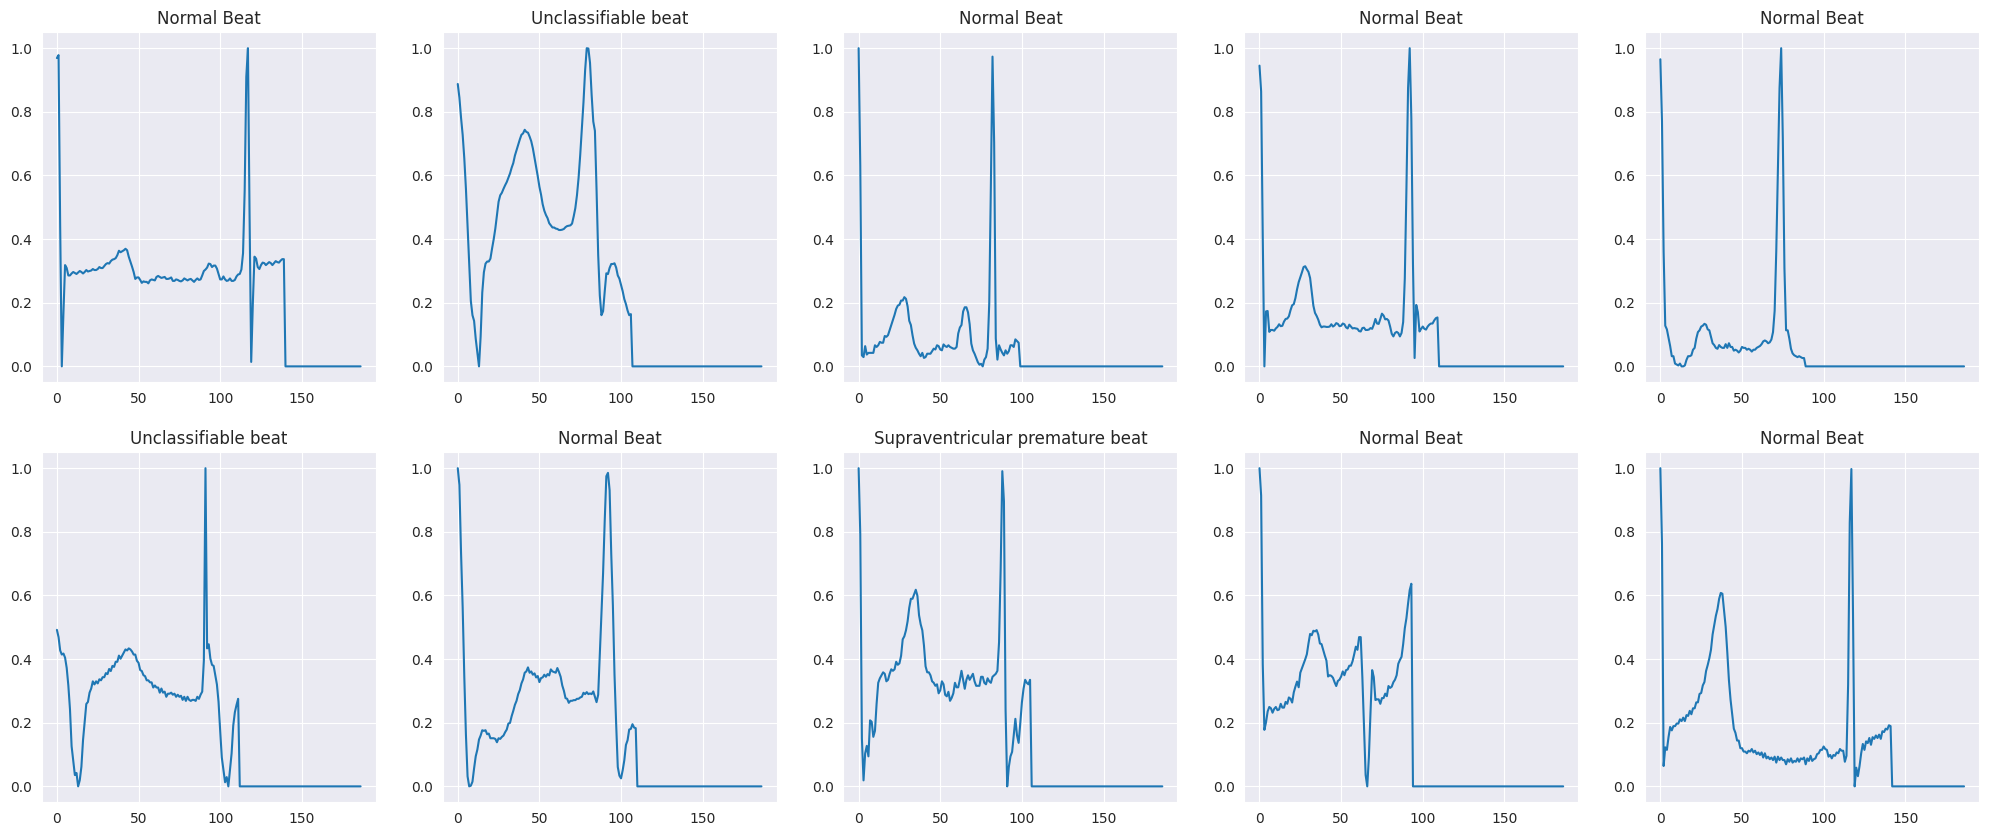

In [ ]:
#Plotting 10 random samples from the MIT training dataset with their classification
plt.figure(figsize=(25,10))
np_count = np.linspace(0,186,187)
np_time = np.tile(np_count,(10,1))
rnd = np.random.randint(0,mit_train.shape[0],size=(10,))


for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    ax.plot(mit_train.iloc[rnd[i],np_time[i,:]])
    ax.set_title(MIT_Outcome[mit_train.loc[rnd[i],'Class']])

plt.show()

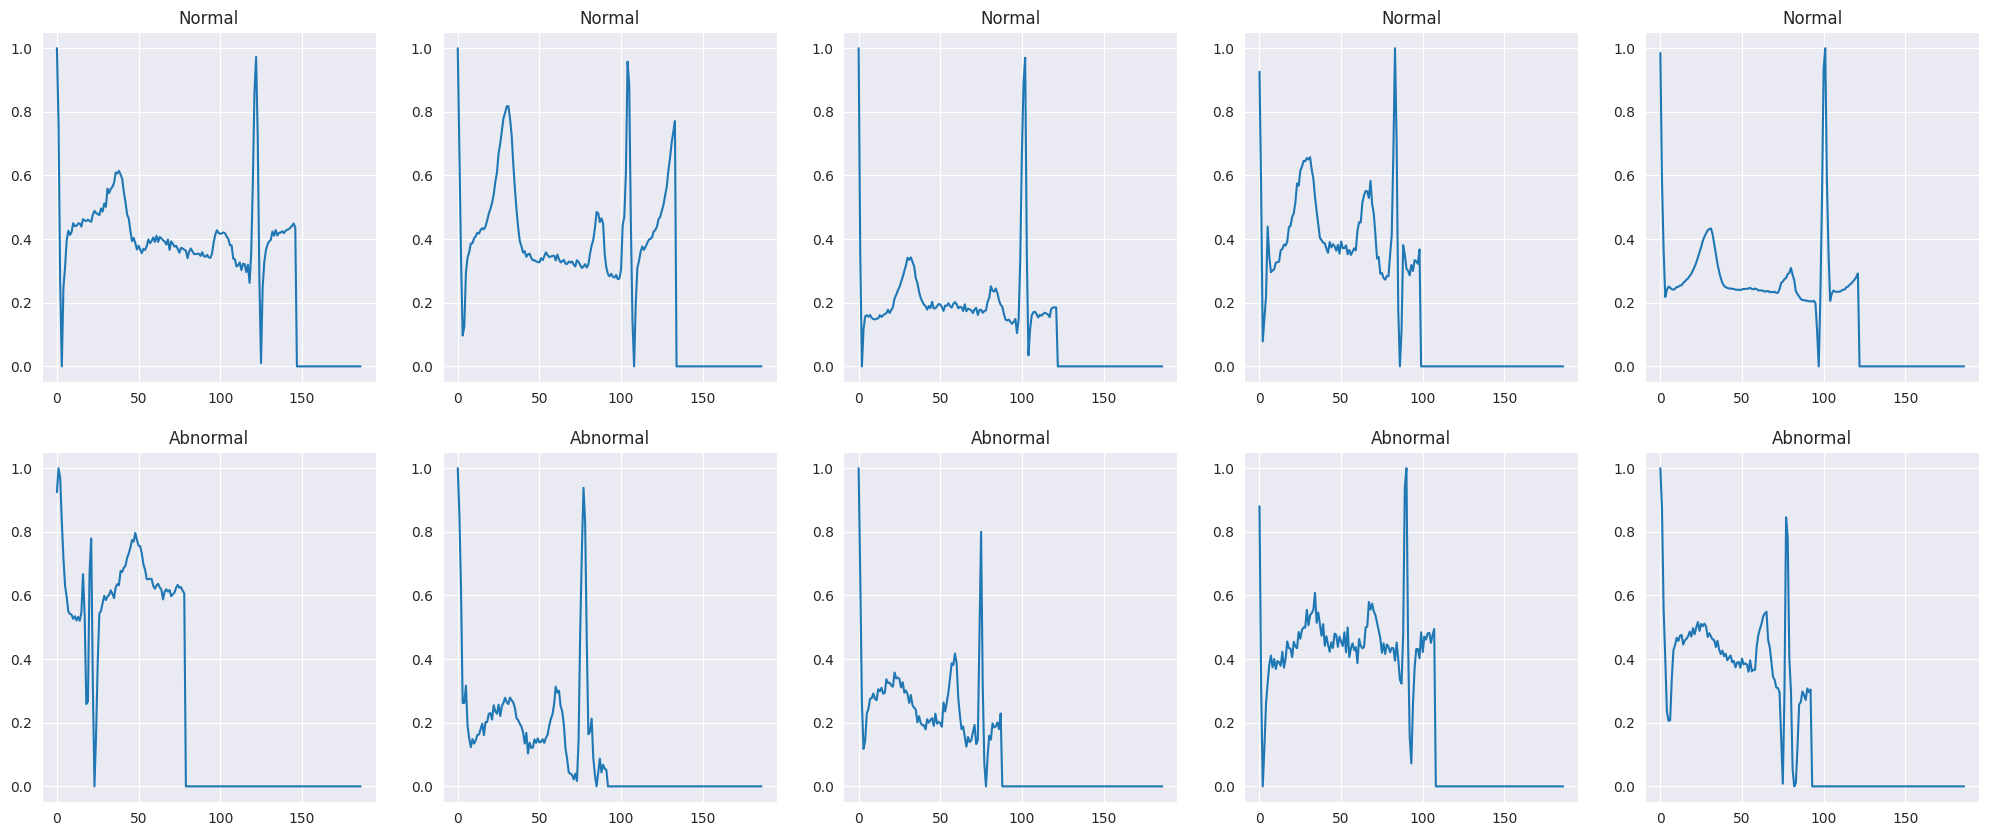

In [ ]:
#Plotting 10 random samples from the PTB training dataset with their classification
plt.figure(figsize=(25,10))
rnd = np.random.randint(0,ptb_normal.shape[0],size=(5,))
rnd1 = np.random.randint(0,ptb_abnormal.shape[0], size=(5,))

for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    if (i < 5):
        ax.plot(ptb_normal.iloc[rnd[i],np_time[i,:]])
        ax.set_title(PTB_Outcome[ptb_normal.loc[rnd[i],'Class']])
    else:
        ax.plot(ptb_abnormal.iloc[rnd1[i-5],np_time[i,:]])
        ax.set_title(PTB_Outcome[ptb_abnormal.loc[rnd1[i-5],'Class']])

plt.show()

# **Deep Learning Analysis**

This is the where the notebooks are different. Tha analysis above is similar to the Baseline version

In [ ]:
#Preparing the training, validation and test sets for the PTB Data set
ptb_full = pd.concat([ptb_normal, ptb_abnormal], axis=0).reset_index()
ptb_full.drop(columns='index', inplace=True)
ptb_full = ptb_full.sample(ptb_full.shape[0], random_state=42)
train_ptb, test_ptb, out_train_ptb, out_test_ptb = train_test_split(ptb_full.iloc[:,:187], ptb_full.iloc[:,-1], test_size=0.15, random_state=42)
train_ptb, valid_ptb, out_train_ptb, out_valid_ptb = train_test_split(train_ptb, out_train_ptb, test_size=0.2, random_state=42 )


# **Calculating the class weight**

Create a dictionary of each class weight to feed into the model since the data is imbalanced

In [ ]:
normal, abnormal = np.bincount(ptb_full.loc[:,'Class'])
norm_weight = (1/normal) * ((normal+abnormal)/2)
abnorm_weight = (1/abnormal) * ((normal+abnormal)/2)
class_weight = {0: norm_weight, 1: abnorm_weight}

In [ ]:
print("Traing dataset size: ", train_ptb.shape)
print("Validation dataset size: ", valid_ptb.shape)
print("Test dataset size: ", test_ptb.shape)

Traing dataset size:  (9895, 187)
Validation dataset size:  (2474, 187)
Test dataset size:  (2183, 187)


In [ ]:
#Normalizing the training, validation & test data
train_ptb = normalize(train_ptb, axis=0, norm='max')
valid_ptb = normalize(valid_ptb, axis=0, norm='max')
test_ptb = normalize(test_ptb, axis=0, norm='max')

In [ ]:
# Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)
x_train_ptb = train_ptb.reshape(len(train_ptb),train_ptb.shape[1],1)
x_valid_ptb = valid_ptb.reshape(len(valid_ptb),valid_ptb.shape[1],1)
x_test_ptb = test_ptb.reshape(len(test_ptb),test_ptb.shape[1],1)

# Converting the output into a categorical array
y_train_ptb = to_categorical(out_train_ptb)
y_valid_ptb = to_categorical(out_valid_ptb)
y_test_ptb = to_categorical(out_test_ptb)

In [ ]:
print("Traing dataset size: ", x_train_ptb.shape , " -- Y size: ", y_train_ptb.shape)
print("Validation dataset size: ", x_valid_ptb.shape , " -- Y size: ", y_valid_ptb.shape)
print("Test dataset size: ", x_test_ptb.shape , " -- Y size: ", y_test_ptb.shape)

Traing dataset size:  (9895, 187, 1)  -- Y size:  (9895, 2)
Validation dataset size:  (2474, 187, 1)  -- Y size:  (2474, 2)
Test dataset size:  (2183, 187, 1)  -- Y size:  (2183, 2)


# **Defining Conv1D model for PTB**

Creating a model based on a series of Conv1D layers that are connected to another series of full connected dense layers

In [ ]:
tf.keras.backend.clear_session()

#Function to build Convolutional 1D Networks
def build_conv1d_model (input_shape=(x_train_ptb.shape[1],1)):
    model = keras.models.Sequential()

    model.add(Conv1D(32,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(64,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(128,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(256,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(512,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2,"micro")])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("conv1d_ptb.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model_conv1d_ptb= build_conv1d_model(input_shape=(x_train_ptb.shape[1], x_train_ptb.shape[2]))
model_conv1d_ptb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 32)           256       
                                                                 
 batch_normalization (BatchN  (None, 187, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 187, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 64)            14400     
                                                                 
 batch_normalization_1 (Batc  (None, 38, 64)           2

In [ ]:
history_conv1d_ptb = model_conv1d_ptb.fit(x_train_ptb, y_train_ptb, epochs=2, batch_size=32,
                                          class_weight=class_weight, validation_data=(x_valid_ptb, y_valid_ptb),
                                          callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/2
310/310 [==============================] - 45s 145ms/step - loss: 0.2749 - f1_score: 0.8904 - val_loss: 0.8964 - val_f1_score: 0.7175
Epoch 2/2
310/310 [==============================] - 54s 175ms/step - loss: 0.1903 - f1_score: 0.9264 - val_loss: 0.1387 - val_f1_score: 0.9365


In [ ]:
model_conv1d_ptb.load_weights("conv1d_ptb.h5")
model_conv1d_ptb.evaluate(x_test_ptb,y_test_ptb)

In [ ]:
# Calculating the predictions based on the highest probability class
conv1d_pred_proba_ptb = model_conv1d_ptb.predict (x_test_ptb)
conv1d_pred_ptb = np.argmax(conv1d_pred_proba_ptb, axis=1)

In [ ]:
print(classification_report(out_test_ptb, conv1d_pred_ptb > 0.5, target_names=[PTB_Outcome[i] for i in PTB_Outcome]))

In [ ]:
cm = confusion_matrix(y_true= out_test_ptb, y_pred=conv1d_pred_ptb, labels=list(PTB_Outcome.keys()))
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Oranges")
plt.colorbar()
plt.xticks(list(PTB_Outcome.keys()),[PTB_Outcome[i] for i in PTB_Outcome], rotation=90)
plt.yticks(list(PTB_Outcome.keys()),[PTB_Outcome[i] for i in PTB_Outcome])
plt.show()

In [ ]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_ptb.epoch, history_conv1d_ptb.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **MIT Dataset Analysis**

In [ ]:
# Since the MIT dataset already comes as a train set and test set, we just split 20% of the training set for validation
train_mit, valid_mit, out_train_mit, out_valid_mit = train_test_split(mit_train.iloc[:,:187], mit_train.iloc[:,-1], test_size=0.20, random_state=42)

#we remove the targets from the test set
test_mit, out_test_mit = mit_test.iloc[:,:187], mit_test.iloc[:,-1]

#Normalizing the training & test data
train_mit = normalize(train_mit, axis=0, norm='max')
valid_mit = normalize(valid_mit, axis=0, norm='max')
test_mit = normalize(test_mit, axis=0, norm='max')


In [ ]:
# Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)
x_train_mit = train_mit.reshape(len(train_mit),train_mit.shape[1],1)
x_valid_mit = valid_mit.reshape(len(valid_mit),valid_mit.shape[1],1)
x_test_mit = test_mit.reshape(len(test_mit),test_mit.shape[1],1)

# Converting the output into a categorical array for each class
y_train_mit = to_categorical(out_train_mit)
y_valid_mit = to_categorical(out_valid_mit)
y_test_mit = to_categorical(out_test_mit)

In [ ]:
print("Traing dataset size: ", x_train_mit.shape , " -- Y size: ", y_train_mit.shape)
print("Validation dataset size: ", x_valid_mit.shape , " -- Y size: ", y_valid_mit.shape)
print("Test dataset size: ", x_test_mit.shape , " -- Y size: ", y_test_mit.shape)

Traing dataset size:  (70043, 187, 1)  -- Y size:  (70043, 5)
Validation dataset size:  (17511, 187, 1)  -- Y size:  (17511, 5)
Test dataset size:  (21892, 187, 1)  -- Y size:  (21892, 5)


In [ ]:
# Calculating the class weights dictionary to feed into the model
normalmit, superpre, prevent, fusion, unclass = np.bincount(mit_train.loc[:,'Class'])
total_rec = len(mit_train)
normmit_weight = (1/normalmit) * (total_rec/5)
superpre_weight = (1/superpre) * (total_rec/5)
prevent_weight = (1/prevent) * (total_rec/5)
fusion_weight =  (1/fusion) * (total_rec/5)
unclass_weight = (1/unclass) * (total_rec/5)
class_weight_mit = {0: normmit_weight, 1: superpre_weight, 2: prevent_weight,
               3: fusion_weight, 4: unclass_weight}

**Defining Conv1D model for MIT**

Creating a model based on a series of Conv1D layers that are connected to another series of full connected dense layers

In [ ]:
tf.keras.backend.clear_session()

#Function to build Convolutional 1D Networks
def build_conv1d_model_mit (input_shape=(x_train_mit.shape[1],1)):
    model = keras.models.Sequential()

    model.add(Conv1D(32,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(64,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(128,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(256,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(512,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(5,"micro")])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("conv1d_mit.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model_conv1d_mit= build_conv1d_model_mit(input_shape=(x_train_mit.shape[1], x_train_mit.shape[2]))
model_conv1d_mit.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 32)           256       
                                                                 
 batch_normalization (BatchN  (None, 187, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 187, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 64)            14400     
                                                                 
 batch_normalization_1 (Batc  (None, 38, 64)           2

In [ ]:
history_conv1d_mit = model_conv1d_mit.fit(x_train_mit, y_train_mit, epochs=2, batch_size=32,
                             class_weight=class_weight_mit, validation_data=(x_valid_mit, y_valid_mit),
                             callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/2
2189/2189 [==============================] - 333s 151ms/step - loss: 0.8390 - f1_score: 0.5558 - val_loss: 0.6305 - val_f1_score: 0.8245
Epoch 2/2
2189/2189 [==============================] - 292s 133ms/step - loss: 0.6175 - f1_score: 0.7171 - val_loss: 0.5124 - val_f1_score: 0.8246


In [ ]:
model_conv1d_mit.load_weights("conv1d_mit.h5")
model_conv1d_mit.evaluate(x_test_mit, y_test_mit)
conv1d_pred_mit_proba = model_conv1d_mit.predict (x_test_mit)
conv1d_pred_mit = np.argmax(conv1d_pred_mit_proba,axis=1)

In [ ]:
print(classification_report(out_test_mit, conv1d_pred_mit, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

In [ ]:
cm = confusion_matrix(y_true= out_test_mit, y_pred=conv1d_pred_mit, labels=list(MIT_Outcome.keys()))
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Oranges")
plt.colorbar()
plt.xticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome], rotation=90)
plt.yticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome])
plt.show()

In [ ]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()